In [63]:
import numpy as np
import torch
import time
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn import functional as F

### **Softmax Attention**

In standard transformers, Softmax Attention is used to compute attention scores.
   $$
   \text{SoftmaxAttn}(X) = \text{Softmax}\left( \frac{QK^T}{\sqrt{d_{qk}}} \right) V
   $$

- **Q** (queries), **K** (keys), and **V** (values) are computed from the input \(X\) by applying linear transformations:
  $$
  Q = XW_q, \quad K = XW_k, \quad V = XW_v
  $$
  where $W_q$, $W_k$, and $W_v$ are learnable weight matrices.
  
- The **Softmax** operation normalizes the dot-product attention scores, ensuring the attention weights sum up to 1 for each token in the sequence. The softmax operation is performed over the dot products of queries and keys:
  $$
  \frac{QK^T}{\sqrt{d_{qk}}}
  $$
  where $d_{qk}$ is the dimensionality of the query/key vectors. The scaling by $sqrt{d_{qk}}$ prevents the values from growing too large as the dimensionality increases, which would make the softmax gradients too small.

In [64]:
class SoftmaxAttention(nn.Module):
    def __init__(self, feature_dim, heads):
        super(SoftmaxAttention, self).__init__()
        self.feature_dim = feature_dim
        self.heads = heads
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
    
    def forward(self, X):
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)
        
        # Classic softmax attention: Eq. (2) in the paper
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.feature_dim)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output

### **Sigmoid Attention**

Replaces the softmax normalization step with an element-wise sigmoid activation function.

$$
\text{SigmoidAttn}(X) = \sigma\left( \frac{QK^T}{\sqrt{d_{qk}}} \right) V
$$

- The same **Q**, **K**, and **V** matrices are computed from the input.
- Has an element-wise sigmoid function $sigma(x)$ = $\frac{1}{1 + e^{-x}}$ to the scaled dot products between queries and keys:
  $$
  \sigma\left( \frac{QK^T}{\sqrt{d_{qk}}} \right)
  $$
  
  The sigmoid function outputs values between 0 and 1, but unlike softmax, it does not enforce the attention weights to sum to 1 across the sequence. This introduces a different kind of regularization to the attention mechanism in which the output becomes:

$$
y_i = \sum_{j=1}^{n} \frac{\exp(\langle W_q x_i, W_k x_j \rangle)}{\exp(\langle W_q x_i, W_k x_j \rangle) + n} W_v x_j
$$

As $n \to \infty$, this equation converges to:

$$
y_i \rightarrow \int \frac{\exp(\langle W_q x_i, W_k x \rangle)}{\exp(\langle W_q x_i, W_k x \rangle)} W_v x d\mu(x)
$$

- $y_i$ represents the output for the $i$-th token.
- $\langle W_q x_i, W_k x_j \rangle$ is the dot product between the query of token $i$ and the key of token $j$, which influences the attention weight assigned to each token.
- The term $\exp(\langle W_q x_i, W_k x_j \rangle)$ appears in both the numerator and the denominator, and as the sequence length $n$ becomes very large, this fraction tends towards a constant.



In [65]:
class SigmoidAttention(nn.Module):
    def __init__(self, feature_dim, heads):
        super(SigmoidAttention, self).__init__()
        self.feature_dim = feature_dim
        self.heads = heads
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
    
    def forward(self, X):
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)
        
        # Eq. (3) from the Sigmoid Attention Paper
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.feature_dim)
        attention_weights = torch.sigmoid(attention_scores)  # Sigmoid replaces softmax
        output = torch.matmul(attention_weights, V)
        return output

### **Toy Experiment (Sigmoid VS Softmax Attention)** 

Here we will train a simplified nanoGPT on shakespare dataset with sigmoid attention and compare performance with softmax for single and multi-head attentions

In [67]:
# Preprocess data
with open('data/input.txt', 'r') as f:
    text = f.read()

# Create a character-level vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create mappings from characters to integers and vice versa
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}

# Encode the entire text
data = torch.tensor([stoi[c] for c in text], dtype=torch.long)

# Split into train and test sets (90% train, 10% test)
n = int(0.9 * len(data))
train_data = data[:n]
test_data = data[n:]

# Save binaries
torch.save(train_data, 'data/train.bin')
torch.save(test_data, 'data/test.bin')

print(f"Vocabulary size: {vocab_size} (number of unique characters in dataset)")
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Vocabulary size: 65 (number of unique characters in dataset)
Train data size: 1003854
Test data size: 111540


### **Simplified nanoGPT**

In [70]:
# Builds on Kapathy's nanoGPT
import math
import torch
import torch.nn as nn
from torch.nn import functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, head_size, n_embd, block_size, dropout, use_sigmoid=False):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if self.use_sigmoid:
            wei = torch.sigmoid(wei)
        else:
            wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout, use_sigmoid=False):
        super().__init__()
        self.heads = nn.ModuleList([SingleHeadAttention(head_size, n_embd, block_size, dropout, use_sigmoid) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout, use_sigmoid=False):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout, use_sigmoid)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class nanoGPT(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout, use_sigmoid=False):
        super().__init__()
        self.block_size = block_size
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout, use_sigmoid) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.config = type('Config', (), {
            'n_layer': n_layer,
            'n_head': n_head,
            'n_embd': n_embd,
            'block_size': block_size,
            'vocab_size': vocab_size,
        })

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = sum(p.numel() for p in self.parameters())
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] # focus only on the last time step
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### **Train**

In [69]:
# Hyperparameters
batch_size = 12
block_size = 64
max_iters = 4000
eval_interval = 200
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 10
n_embd = 128
n_head = 4
n_layer = 4
dropout = 0

# Load data
train_data = torch.load('data/train.bin', weights_only=False)
test_data = torch.load('data/test.bin', weights_only=False)

def get_batch(split):
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def train_model(model, model_type):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    # For calculating MFU (Model Flops Utilization)
    t0 = time.time()
    local_iter_num = 0
    running_mfu = -1.0
    
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

        # sample a batch of data
        xb, yb = get_batch('train')

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # timing and logging
        t1 = time.time()
        dt = t1 - t0
        t0 = t1
        if iter % 10 == 0:
            # get loss as float. note: this is a CPU-GPU sync point
            lossf = loss.item()
            if local_iter_num >= 5: # let the training loop settle a bit
                mfu = model.estimate_mfu(batch_size * block_size, dt)
                running_mfu = mfu if running_mfu == -1.0 else 0.9*running_mfu + 0.1*mfu
            print(f"iter {iter}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
        local_iter_num += 1
        
        if iter % 1000 == 0:
            print(f"saving checkpoint to out-{model_type}")
            torch.save(model.state_dict(), f"checkpoints/out-{model_type}.pt")

    return train_losses, val_losses

# Add this method to your GPTLanguageModel class
def estimate_mfu(self, fwdbwd_per_iter, dt):
    """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
    # first estimate the number of flops we do per iteration.
    # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
    N = sum(p.numel() for p in self.parameters())
    cfg = self.config
    L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
    flops_per_token = 6*N + 12*L*H*Q*T
    flops_per_fwdbwd = flops_per_token * T
    flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
    # express our flops throughput as ratio of A100 bfloat16 peak flops
    flops_achieved = flops_per_iter * (1.0/dt) # per second
    flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
    mfu = flops_achieved / flops_promised
    return mfu

In [71]:
# Train with sigmoid attention
print("Training With Softmax Attention")
model_sigmoid = nanoGPT(vocab_size, n_embd, block_size, n_head, n_layer, dropout, use_sigmoid=True)
model_sigmoid = model_sigmoid.to(device)
train_losses_sigmoid, test_losses_sigmoid = train_model(model_sigmoid, "Sigmoid")

Training With Softmax Attention
step 0: train loss 4.3226, val loss 4.3094
iter 0: loss 4.3172, time 262.85ms, mfu -100.00%
saving checkpoint to out-Sigmoid
iter 10: loss 3.3473, time 25.24ms, mfu 3.30%
iter 20: loss 3.4084, time 28.34ms, mfu 3.27%
iter 30: loss 3.3309, time 24.76ms, mfu 3.28%
iter 40: loss 3.2824, time 26.12ms, mfu 3.27%
iter 50: loss 3.2582, time 27.85ms, mfu 3.24%
iter 60: loss 3.2619, time 25.72ms, mfu 3.24%
iter 70: loss 3.3017, time 28.23ms, mfu 3.21%
iter 80: loss 3.0144, time 28.18ms, mfu 3.19%
iter 90: loss 3.0160, time 27.98ms, mfu 3.17%
iter 100: loss 2.8799, time 25.85ms, mfu 3.17%
iter 110: loss 2.7632, time 32.00ms, mfu 3.12%
iter 120: loss 2.7708, time 25.46ms, mfu 3.13%
iter 130: loss 2.7243, time 26.75ms, mfu 3.13%
iter 140: loss 2.7691, time 28.18ms, mfu 3.11%
iter 150: loss 2.6791, time 27.94ms, mfu 3.10%
iter 160: loss 2.6737, time 24.35ms, mfu 3.13%
iter 170: loss 2.6021, time 27.21ms, mfu 3.13%
iter 180: loss 2.5726, time 28.32ms, mfu 3.11%
iter 1

In [72]:
# Train with softmax attention
print("Training With Softmax Attention")
model_softmax = nanoGPT(vocab_size, n_embd, block_size, n_head, n_layer, dropout, use_sigmoid=False)
model_softmax = model_softmax.to(device)
train_losses_softmax, test_losses_softmax = train_model(model_softmax, "Softmax")


Training With Softmax Attention
step 0: train loss 4.3452, val loss 4.3566
iter 0: loss 4.3652, time 168.84ms, mfu -100.00%
saving checkpoint to out-Softmax
iter 10: loss 3.4071, time 29.08ms, mfu 2.87%
iter 20: loss 3.2465, time 27.62ms, mfu 2.88%
iter 30: loss 3.2501, time 25.94ms, mfu 2.92%
iter 40: loss 3.0229, time 26.67ms, mfu 2.94%
iter 50: loss 3.0703, time 24.86ms, mfu 2.98%
iter 60: loss 2.9342, time 24.09ms, mfu 3.03%
iter 70: loss 2.8410, time 23.29ms, mfu 3.08%
iter 80: loss 2.7101, time 24.52ms, mfu 3.11%
iter 90: loss 2.6872, time 23.28ms, mfu 3.16%
iter 100: loss 2.7477, time 27.88ms, mfu 3.14%
iter 110: loss 2.7051, time 26.95ms, mfu 3.14%
iter 120: loss 2.6606, time 27.49ms, mfu 3.13%
iter 130: loss 2.6660, time 22.61ms, mfu 3.18%
iter 140: loss 2.6813, time 23.28ms, mfu 3.22%
iter 150: loss 2.5488, time 25.11ms, mfu 3.23%
iter 160: loss 2.6517, time 23.95ms, mfu 3.26%
iter 170: loss 2.5588, time 25.95ms, mfu 3.25%
iter 180: loss 2.5452, time 35.26ms, mfu 3.17%
iter 1

### **Evaluate**

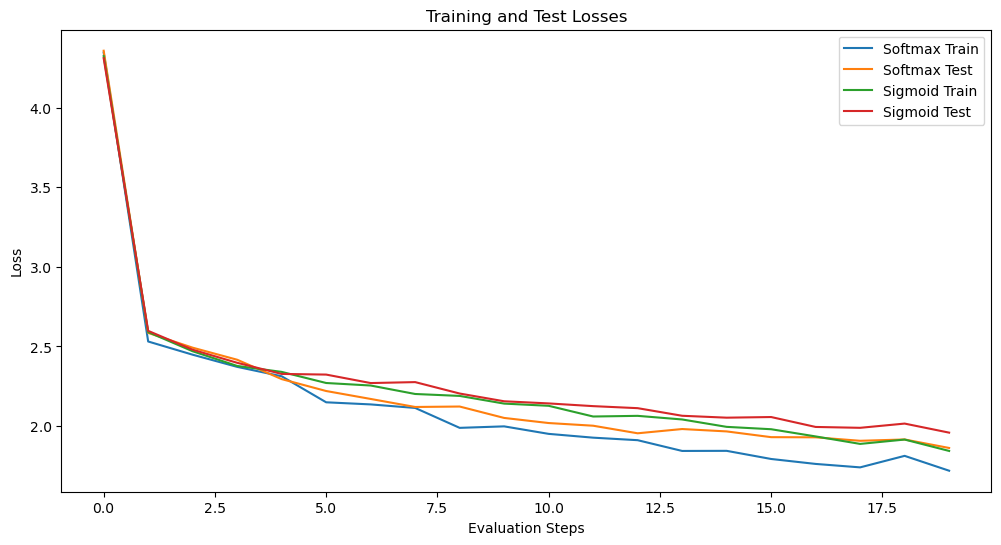

Softmax Attention Generated Text:
First Citizen:
Mehery Mose for wail, to am thirse: comanincess.
So the peast thy wirlace, you: ip him.

WARY Sigha

Sigmoid Attention Generated Text:
First Citizen:
Forie with yat sorsent his forcaty:
Sewere thop enoto detltsemang.

NENIUSS:
I dim he seenlanceor f


In [73]:
import matplotlib.pyplot as plt
import torch
import math

# Load the saved weights
model_softmax.load_state_dict(torch.load('checkpoints/out-softmax.pt', weights_only=False))
model_sigmoid.load_state_dict(torch.load('checkpoints/out-sigmoid.pt', weights_only=False))

# Plot training and test losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses_softmax, label='Softmax Train')
plt.plot(test_losses_softmax, label='Softmax Test')
plt.plot(train_losses_sigmoid, label='Sigmoid Train')
plt.plot(test_losses_sigmoid, label='Sigmoid Test')
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

# Generate text samples
def generate_text(model, prompt, max_new_tokens=100):
    model.eval()
    context = torch.tensor([stoi[c] for c in prompt], dtype=torch.long, device=device).unsqueeze(0)
    generated = model.generate(context, max_new_tokens=max_new_tokens)[0]
    return ''.join([itos[int(i)] for i in generated])

prompt = "First Citizen:"
print("Softmax Attention Generated Text:")
print(generate_text(model_softmax, prompt))
print("\nSigmoid Attention Generated Text:")
print(generate_text(model_sigmoid, prompt))

# Compare perplexity
@torch.no_grad()
def calculate_perplexity(model, data):
    model.eval()
    total_loss = 0
    total_tokens = 0
    for i in range(0, len(data) - block_size, block_size):
        x = data[i:i+block_size].unsqueeze(0).to(device)
        y = data[i+1:i+block_size+1].unsqueeze(0).to(device)
        logits, loss = model(x, y)
        total_loss += loss.item() * block_size
        total_tokens += block_size
    return math.exp(total_loss / total_tokens)

In [74]:
softmax_perplexity = calculate_perplexity(model_softmax, test_data)
sigmoid_perplexity = calculate_perplexity(model_sigmoid, test_data)

print(f"Softmax Attention Perplexity: {softmax_perplexity:.2f}")
print(f"Sigmoid Attention Perplexity: {sigmoid_perplexity:.2f}")

Softmax Attention Perplexity: 6.94
Sigmoid Attention Perplexity: 7.77
